# Construct a binary tree from sklearn decision tree classifier

Sklearn decision trees store their trees as preorder depth first searches. To illustrate how to construct a hierarchical object that can be saved as JSON and loaded to D3, we can look at a simple dataset as the iris.

In [4]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn import tree
import graphviz
import json
from brewer2mpl import qualitative
import pickle
iris = load_iris()
num_classes = 2
if num_classes < 3:
    num_classes = 3
# colors for subsequent decision tree plotting
colors = qualitative.Dark2[num_classes].hex_colors
clf = pickle.load(open('../data/decision_tree_AIDS_5lvl.pickle','rb'))


/home/adam/.pyenv/versions/3.6.0/envs/python36/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


The results are stored in 

In [5]:
clf.tree_.feature

array([58,  1, 54, 58, 58, -2, -2, 12, -2, -2, 58, 16, -2, -2, 58, -2, -2,
       58, 58, 20, -2, -2, 60, -2, -2, 58, 58, -2, -2, 62, -2, -2, 58, 12,
        1, 14, -2, -2, 58, -2, -2,  1,  9, -2, -2, 50, -2, -2, 58,  1, 13,
       -2, -2, 50, -2, -2,  0, 50, -2, -2, 50, -2, -2])

or in clf.tree_.__getstate__()['nodes']

Concentrate on a few features from the dataset:

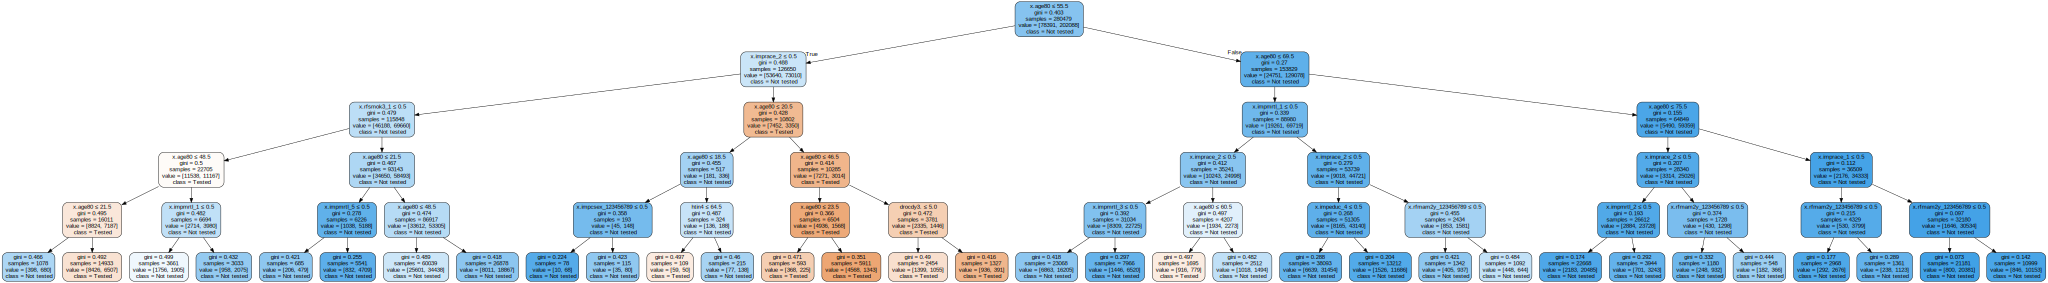

In [9]:

feature_names = ['x.imprace_1', 'x.imprace_2', 'x.imprace_3', 'x.imprace_4',
       'x.imprace_5', 'x.imprace_6', 'x.impeduc_1', 'x.impeduc_2',
       'x.impeduc_3', 'x.impeduc_4', 'x.impeduc_5', 'x.impeduc_6',
       'x.impmrtl_1', 'x.impmrtl_2', 'x.impmrtl_3', 'x.impmrtl_4',
       'x.impmrtl_5', 'x.impmrtl_6', 'x.impcsex_1', 'x.impcsex_2',
       'x.impcsex_123456789', 'x.asthms1_1', 'x.asthms1_2', 'x.asthms1_3',
       'x.asthms1_9', 'x.incomg_1', 'x.incomg_2', 'x.incomg_3',
       'x.incomg_4', 'x.incomg_5', 'x.incomg_9', 'x.rfseat3_1',
       'x.rfseat3_2', 'x.rfseat3_9', 'x.flshot6_1', 'x.flshot6_2',
       'x.flshot6_9', 'x.flshot6_123456789', 'x.pneumo2_1', 'x.pneumo2_2',
       'x.pneumo2_9', 'x.pneumo2_123456789', 'x.bmi5cat_1', 'x.bmi5cat_2',
       'x.bmi5cat_3', 'x.bmi5cat_4', 'x.bmi5cat_123456789', 'x.rfmam2y_1',
       'x.rfmam2y_2', 'x.rfmam2y_9', 'x.rfmam2y_123456789', 'x.denvst2_1',
       'x.denvst2_2', 'x.denvst2_9', 'x.rfsmok3_1', 'x.rfsmok3_2',
       'x.rfsmok3_9', 'sleptim1', 'x.age80', 'x.impnph', 'htin4', 'wtkg3',
       'drocdy3.', 'x.drnkmo4']

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=feature_names,  
                         class_names=['Tested','Not tested'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## tree construction

We can reconstruct the decision tree by using stacks. Alternatively, we could us recursios.

In [10]:
from collections import deque

# it is currently superfluous to have a node class but might be useful in the future
class Node:
    
    COUNTER = 0
    
    def __init__(self, name):
        self.name = name
        self.children = []
        Node.COUNTER += 1
    
    def add_child(self, child):
        self.children.append(child)

# data for reconstructing the tree
features = clf.tree_.feature
n_samples = clf.tree_.n_node_samples
feature_names = feature_names
values = clf.tree_.value # is it weighted?
thresholds = np.round(clf.tree_.threshold,2)
classes = clf.tree_.predict

# set containers
leaves = deque()
nodes = []

# helper functions
def value_getter(arr):
    return [int(v) for v in arr[0]]


# count the leaf nodes in the tree in order to return a little bit nicer formatted output
n_leaf = sum([feature == -2 for feature in features])

# build the tree in a bottom-up approach
for n, feature in enumerate(reversed(features)):
    this_value = value_getter(values[-(n+1)])
    this_label = feature_names[feature] + '<' + str(thresholds[-(n+1)])
    # if it is a leaf node, append it to leaves and give it a name
    if feature == -2:
        leaf = {'label': 'leaf' + str(n_leaf), 'samples': sum(this_value), 'value': this_value,
                'color': colors[np.argmax(this_value)]}
        leaves.append(leaf)
        n_leaf -= 1
    # if it is a node, append it to the tree
    else:
  #      node = Node(feature_names[feature])
  #      print(node.COUNTER)
  #      nodes.append(node)
        # add left and right children to the stack
        child1=leaves.pop()
        child2=leaves.pop()
        # temporary stack to store the children
        temp_leaves = []
        # and the nodes 
        temp_node_leaves = {'label': this_label , 'samples': sum(this_value), 
                            'value': this_value, 'color': colors[np.argmax(this_value)]}
        temp_leaves.append(child1)
        temp_leaves.append(child2)
        temp_node_leaves['children'] = temp_leaves
        leaves.append(temp_node_leaves)
reconstructed_tree = temp_node_leaves
reconstructed_tree

{'children': [{'children': [{'children': [{'children': [{'children': [{'color': '#D95F02',
           'label': 'leaf1',
           'samples': 1078,
           'value': [398, 680]},
          {'color': '#1B9E77',
           'label': 'leaf2',
           'samples': 14933,
           'value': [8426, 6507]}],
         'color': '#1B9E77',
         'label': 'x.age80<21.5',
         'samples': 16011,
         'value': [8824, 7187]},
        {'children': [{'color': '#D95F02',
           'label': 'leaf3',
           'samples': 3661,
           'value': [1756, 1905]},
          {'color': '#D95F02',
           'label': 'leaf4',
           'samples': 3033,
           'value': [958, 2075]}],
         'color': '#D95F02',
         'label': 'x.impmrtl_1<0.5',
         'samples': 6694,
         'value': [2714, 3980]}],
       'color': '#1B9E77',
       'label': 'x.age80<48.5',
       'samples': 22705,
       'value': [11538, 11167]},
      {'children': [{'children': [{'color': '#D95F02',
           'lab

Add options for sankey-widget.js

In [12]:
tree = {}
tree['data'] = reconstructed_tree
tree['opts'] = {
      "childrenName": "children", 
      "id": "id", 
      "maxLabelLength": 15, 
      "name": "label", 
      "nodeHeight": None, 
      "tooltip": None, 
      "treeColors": False, 
      "value": "samples"
    }



In [12]:
importances = []
for feature, importance in zip(feature_names, clf.feature_importances_):
    importances.append({'attribute': feature, 'importance': importance})

In [13]:
json_out = {'evals': [], 'jsHooks': [], 'x': tree, 'importances': importances}

With a little bit nicer formatting, we can see that this corresponds to the structure that d3 tree layout expects.

In [14]:
print(json.dumps(json_out, indent=4)) 

{
    "evals": [],
    "jsHooks": [],
    "x": {
        "data": {
            "label": "x.age80<55.5",
            "samples": 280479,
            "value": [
                78391,
                202088
            ],
            "color": "#D95F02",
            "children": [
                {
                    "label": "x.imprace_2<0.5",
                    "samples": 126650,
                    "value": [
                        53640,
                        73010
                    ],
                    "color": "#D95F02",
                    "children": [
                        {
                            "label": "x.rfsmok3_1<0.5",
                            "samples": 115848,
                            "value": [
                                46188,
                                69660
                            ],
                            "color": "#D95F02",
                            "children": [
                                {
                             

In [15]:
with open('../data/tree_brfss.json', 'w') as fp:
    json.dump(json_out, fp, indent = 4)